# Consumer Complaint Resolution Prediction Model

Aim of the project is to develop a model that when provided with the user data and the complaint information, is able to predict if the particular complaint could be eliminated in the future.

#### APPLICATIONS : 
Such models could help organisations to improve customer services and fasten up their grievance catering methods in order to prevent piling up of complaints. These models can also be integrated with response mechanisms that can filter out grievances that were similar to some prior catered complaints, avoiding repeated actions. 

### Importing Libraries

In [86]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, precision_score, classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.svm import SVC
from io import StringIO
from imblearn.over_sampling import SMOTE
%matplotlib inline

In [87]:
from datetime import date
import time
import joblib

### Importing dataset and data overview

In [3]:
data = pd.read_csv("consumer_complaints.csv")

C:\Users\Diya Sivaprasad\AppData\Local\Temp\ipykernel_14692\2514161639.py:1: DtypeWarning: Columns (5,11) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("consumer_complaints.csv")


##### Looking into a sample of data 

In [4]:
data.sample(10)

,date_received,product,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,zipcode,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed?,complaint_id
157914,11/21/2014,Debt collection,Payday loan,Disclosure verification of debt,Not given enough info to verify debt,NaN,NaN,Turning Point Solutions LLC,GA,30012,NaN,NaN,Web,11/21/2014,Closed with non-monetary relief,Yes,No,1132659
259490,07/27/2015,Credit card,NaN,Billing disputes,NaN,NaN,NaN,Amex,AZ,85250,NaN,Consent not provided,Web,07/28/2015,Closed with explanation,Yes,Yes,1489237
336007,08/08/2012,Credit card,NaN,Credit determination,NaN,NaN,NaN,Citibank,CA,90064,NaN,NaN,Web,10/25/2012,Closed with explanation,Yes,No,131972
371759,05/20/2013,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,Bank of America,IL,60126,NaN,NaN,Referral,05/20/2013,Closed with explanation,Yes,No,410858
75165,06/05/2014,Debt collection,Medical,Communication tactics,Frequent or repeated calls,NaN,NaN,"Nationwide Credit & Collection, Inc.",IL,60187,NaN,NaN,Web,06/05/2014,Closed with explanation,Yes,Yes,882109
208438,04/13/2015,Mortgage,Conventional adjustable mortgage (ARM),"Loan servicing, payments, escrow account",NaN,Capital One 360 purchased ING Direct ( a year ...,NaN,Capital One,IL,606XX,NaN,Consent provided,Web,04/13/2015,Closed with explanation,Yes,No,1326600
142712,10/15/2014,Debt collection,"Other (i.e. phone, health club, etc.)",Cont'd attempts collect debt not owed,Debt is not mine,NaN,NaN,"AmerAssist A/R Solutions, Inc.",AZ,78525,NaN,NaN,Referral,10/21/2014,Closed,No,No,1071633
306488,11/16/2015,Mortgage,Conventional fixed mortgage,"Loan servicing, payments, escrow account",NaN,NaN,NaN,JPMorgan Chase & Co.,FL,32114,NaN,Consent not provided,Web,11/16/2015,Closed with explanation,Yes,No,1657365
509309,03/12/2016,Consumer Loan,Vehicle loan,Taking out the loan or lease,NaN,NaN,NaN,"Honor Finance Holdings, LLC",IN,46410,NaN,NaN,Web,03/24/2016,Closed with explanation,Yes,Yes,1829424
475538,09/04/2013,Mortgage,Home equity loan or line of credit,"Application, originator, mortgage broker",NaN,NaN,NaN,Citibank,SC,29579,NaN,NaN,Web,09/04/2013,Closed with non-monetary relief,Yes,No,513984


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555957 entries, 0 to 555956
Data columns (total 18 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   date_received                 555957 non-null  object
 1   product                       555957 non-null  object
 2   sub_product                   397635 non-null  object
 3   issue                         555957 non-null  object
 4   sub_issue                     212622 non-null  object
 5   consumer_complaint_narrative  66806 non-null   object
 6   company_public_response       85124 non-null   object
 7   company                       555957 non-null  object
 8   state                         551070 non-null  object
 9   zipcode                       551452 non-null  object
 10  tags                          77959 non-null   object
 11  consumer_consent_provided     123458 non-null  object
 12  submitted_via                 555957 non-null  object
 13 

##### Looking into the info, we infer that there are multiple rows with abundant null values which would not contribute much to prediction

In [6]:
print("shape of the data = ", data.shape)

shape of the data =  (555957, 18)


### Data pre-processing

In [7]:
data.duplicated().sum()

0

In [8]:
data.isnull().sum()

date_received                        0
product                              0
sub_product                     158322
issue                                0
sub_issue                       343335
consumer_complaint_narrative    489151
company_public_response         470833
company                              0
state                             4887
zipcode                           4505
tags                            477998
consumer_consent_provided       432499
submitted_via                        0
date_sent_to_company                 0
company_response_to_consumer         0
timely_response                      0
consumer_disputed?                   0
complaint_id                         0
dtype: int64

##### We'll drop the columns which have more than 25% of null values 

In [9]:
for i in data.columns:
    if(data[i].isnull().sum()/len(data) >= 0.25):
        data = data.drop(i, axis = 1)

In [10]:
data.columns

Index(['date_received', 'product', 'issue', 'company', 'state', 'zipcode',
       'submitted_via', 'date_sent_to_company', 'company_response_to_consumer',
       'timely_response', 'consumer_disputed?', 'complaint_id'],
      dtype='object')

In [11]:
data.isnull().sum()

date_received                      0
product                            0
issue                              0
company                            0
state                           4887
zipcode                         4505
submitted_via                      0
date_sent_to_company               0
company_response_to_consumer       0
timely_response                    0
consumer_disputed?                 0
complaint_id                       0
dtype: int64

##### We are left with only the zipcode and state to deal with

In [12]:
data['state'].nunique()

62

In [13]:
data["state"].value_counts()

state
CA    81700
FL    53673
TX    41352
NY    38266
GA    24548
      ...  
MH       27
MP       19
AS       17
PW        9
AA        9
Name: count, Length: 62, dtype: int64

##### Since the complaints from CA are the highest with a large margin, we can impute the null data with CA and drop the zipcodes

In [14]:
data['state'].fillna("CA", inplace = True)

In [15]:
data = data.drop(['zipcode'], axis = 1)

In [16]:
data['issue'].nunique()

95

In [17]:
data['date_received'] = pd.to_datetime(data['date_received'])
data['date_sent_to_company'] = pd.to_datetime(data['date_sent_to_company'])

In [18]:
data = data.drop(['complaint_id'], axis = 1)

##### We have dropped the IDs since they do not contribute to prediction

In [19]:
data['company_response_to_consumer'].unique()

array(['Closed with explanation', 'Closed with monetary relief',
       'Closed with non-monetary relief', 'Closed', 'Untimely response',
       'In progress', 'Closed without relief', 'Closed with relief'],
      dtype=object)

##### We will take into account the delay in registering the concern to the company and the date and month of the registration

In [20]:
data['latency'] = (data['date_sent_to_company'] - data['date_received']).dt.days

In [21]:
data['day'] = data['date_sent_to_company'].dt.day
data['month'] = data['date_sent_to_company'].dt.month

In [22]:
data = data.drop(['date_received', 'date_sent_to_company'], axis = 1)

In [23]:
data.head()

,product,issue,company,state,submitted_via,company_response_to_consumer,timely_response,consumer_disputed?,latency,day,month
0,Mortgage,"Loan modification,collection,foreclosure",U.S. Bancorp,CA,Referral,Closed with explanation,Yes,Yes,4,3,9
1,Mortgage,"Loan servicing, payments, escrow account",Wells Fargo & Company,CA,Referral,Closed with explanation,Yes,Yes,4,3,9
2,Credit reporting,Incorrect information on credit report,Wells Fargo & Company,NY,Postal mail,Closed with explanation,Yes,No,19,18,9
3,Student loan,Repaying your loan,"Navient Solutions, Inc.",MD,Email,Closed with explanation,Yes,Yes,0,30,8
4,Debt collection,False statements or representation,Resurgent Capital Services L.P.,GA,Web,Closed with explanation,Yes,Yes,0,30,8


##### Checking the number of classes in each categorical column

In [25]:
data['product'].nunique()

11

In [26]:
data['state'].nunique()

62

In [27]:
data['submitted_via'].nunique()

6

In [28]:
data['company_response_to_consumer'].nunique()

8

In [29]:
data['product'].value_counts()

product
Mortgage                   186475
Debt collection            101052
Credit reporting            91854
Credit card                 66468
Bank account or service     62563
Consumer Loan               20990
Student loan                15839
Payday loan                  3877
Money transfers              3812
Prepaid card                 2470
Other financial service       557
Name: count, dtype: int64

### Data Analysis and Visualisation

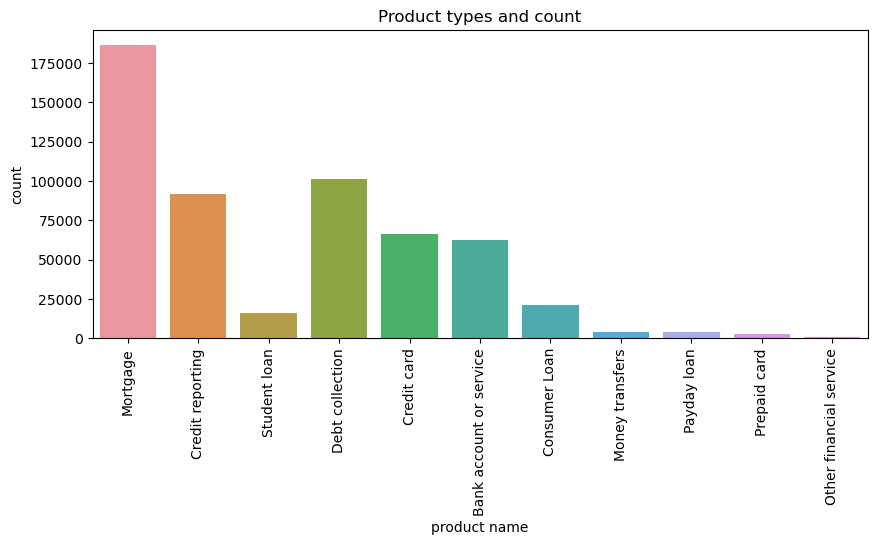

In [30]:
plt.figure(figsize = (10, 4))
fig = sns.countplot(data = data, x = 'product')
fig.set_xticklabels(fig.get_xticklabels(), rotation=90)
plt.xlabel("product name")
plt.title("Product types and count")
plt.show()

##### We find that the most concerns are regarding Mortgages, followed by Debts and Credits

In [31]:
print("percentage share of products in the complaints", data['product'].value_counts()/len(data)*100)

percentage share of products in the complaints product
Mortgage                   33.541263
Debt collection            18.176226
Credit reporting           16.521781
Credit card                11.955601
Bank account or service    11.253208
Consumer Loan               3.775472
Student loan                2.848961
Payday loan                 0.697356
Money transfers             0.685665
Prepaid card                0.444279
Other financial service     0.100188
Name: count, dtype: float64


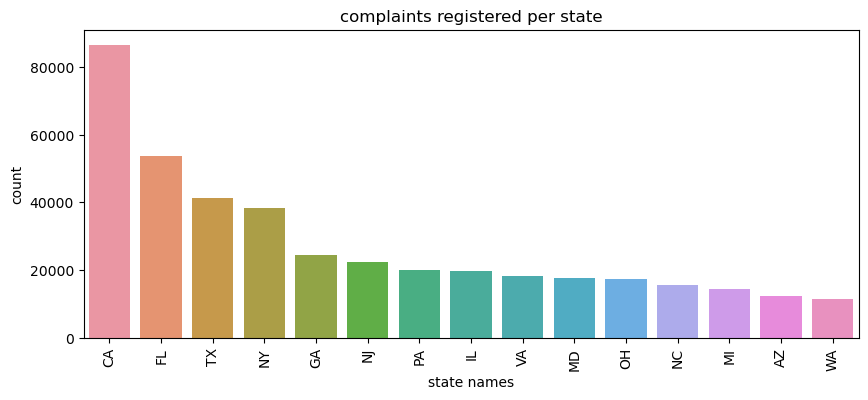

In [32]:
plt.figure(figsize = (10, 4))
fig = sns.countplot(data = data, x = 'state', order=data['state'].value_counts().iloc[:15].index)
fig.set_xticklabels(fig.get_xticklabels(), rotation=90)
plt.xlabel("state names")
plt.title("complaints registered per state")
plt.show()

In [33]:
#CA is the state with the most number of complaints

In [34]:
ca_data = data[data['state'] == 'CA']

In [35]:
print("percentage share of products in the complaints in CA", ca_data['product'].value_counts()/len(ca_data)*100)

percentage share of products in the complaints in CA product
Mortgage                   39.585619
Debt collection            16.482844
Credit reporting           14.522965
Bank account or service    11.237253
Credit card                11.169113
Consumer Loan               2.984282
Student loan                2.093848
Money transfers             0.771478
Payday loan                 0.628270
Prepaid card                0.423851
Other financial service     0.100477
Name: count, dtype: float64


In [36]:
print("percentage share of products in the complaints in CA", ca_data['company_response_to_consumer'].value_counts()/len(ca_data)*100)

percentage share of products in the complaints in CA company_response_to_consumer
Closed with explanation            73.547992
Closed with non-monetary relief    12.012196
Closed with monetary relief         6.168362
Closed without relief               3.770774
Closed                              2.470348
Closed with relief                  0.860406
In progress                         0.706804
Untimely response                   0.463118
Name: count, dtype: float64


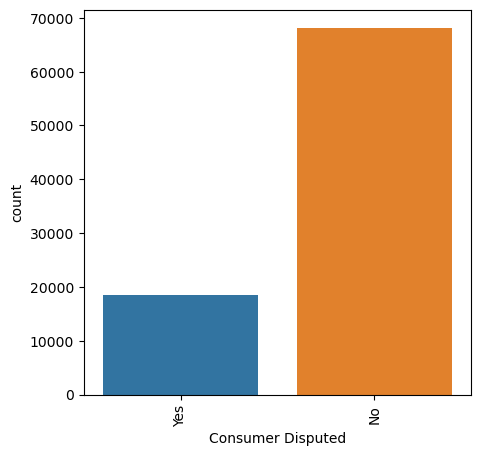

In [37]:
plt.figure(figsize = (5,5))
fig = sns.countplot(data = ca_data, x = 'consumer_disputed?')
fig.set_xticklabels(fig.get_xticklabels(), rotation=90)
plt.xlabel("Consumer Disputed")
plt.show()

In [38]:
#maybe complaints are high because they are being resolved well

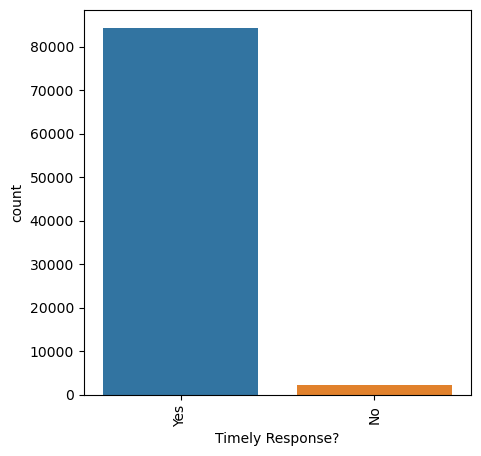

In [39]:
plt.figure(figsize = (5,5))
fig = sns.countplot(data = ca_data, x = 'timely_response')
fig.set_xticklabels(fig.get_xticklabels(), rotation=90)
plt.xlabel("Timely Response?")
plt.show()

In [40]:
#consumers file more complaints in CA because they are catered well

In [41]:
fl_data = data[data['state'] == 'FL']

In [42]:
print("percentage share of products in the complaints in CA", fl_data['product'].value_counts()/len(fl_data)*100)

percentage share of products in the complaints in CA product
Mortgage                   38.447637
Debt collection            17.338327
Credit reporting           16.565126
Bank account or service    10.849030
Credit card                10.524845
Consumer Loan               3.197138
Student loan                1.816556
Money transfers             0.534720
Payday loan                 0.389395
Prepaid card                0.262702
Other financial service     0.074525
Name: count, dtype: float64


In [43]:
print("percentage share of products in the complaints in CA", fl_data['company_response_to_consumer'].value_counts()/len(fl_data)*100)

percentage share of products in the complaints in CA company_response_to_consumer
Closed with explanation            74.482514
Closed with non-monetary relief    12.207255
Closed with monetary relief         6.003018
Closed without relief               3.014551
Closed                              2.209677
Closed with relief                  0.827232
In progress                         0.754569
Untimely response                   0.501183
Name: count, dtype: float64


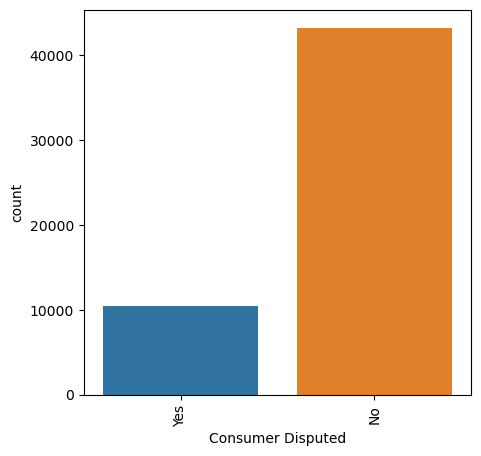

In [44]:
plt.figure(figsize = (5,5))
fig = sns.countplot(data = fl_data, x = 'consumer_disputed?')
fig.set_xticklabels(fig.get_xticklabels(), rotation=90)
plt.xlabel("Consumer Disputed")
plt.show()

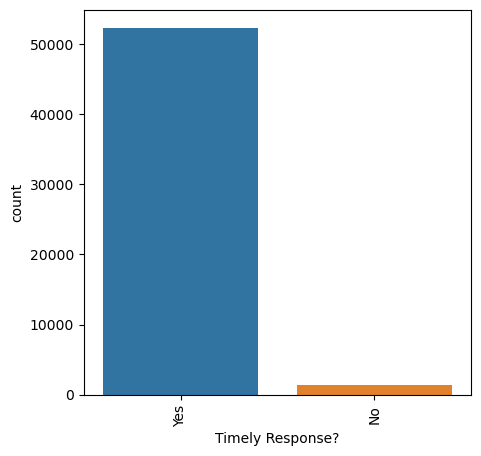

In [45]:
plt.figure(figsize = (5,5))
fig = sns.countplot(data = fl_data, x = 'timely_response')
fig.set_xticklabels(fig.get_xticklabels(), rotation=90)
plt.xlabel("Timely Response?")
plt.show()

##### We observe that in the top 2 states with the most complaints "mortgage" was the highest cause of complaints and the consumers ended up satisfied 

##### It could be concluded that complaints were high in these states because of the efficient resolution of the complaints

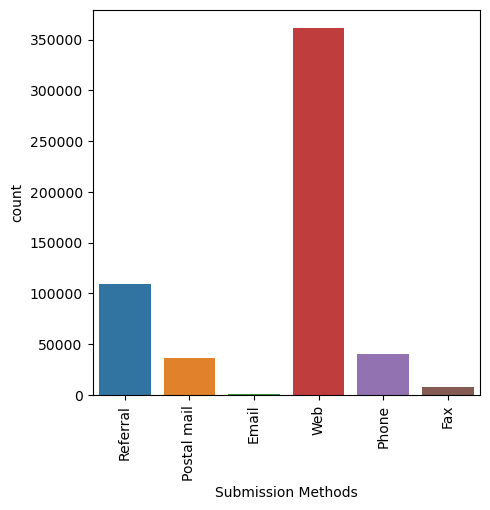

In [47]:
plt.figure(figsize = (5,5))
fig = sns.countplot(data = data, x = 'submitted_via')
fig.set_xticklabels(fig.get_xticklabels(), rotation=90)
plt.xlabel("Submission Methods")
plt.show()

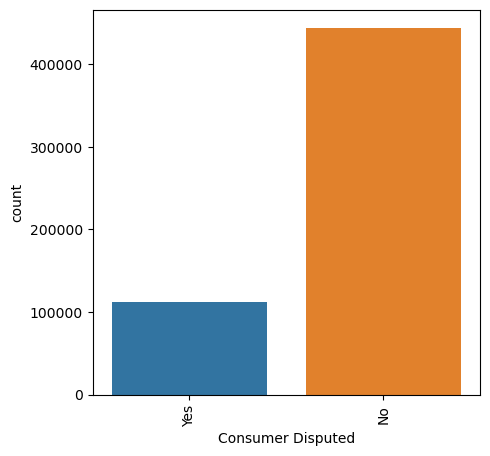

In [48]:
plt.figure(figsize = (5,5))
fig = sns.countplot(data = data, x = 'consumer_disputed?')
fig.set_xticklabels(fig.get_xticklabels(), rotation=90)
plt.xlabel("Consumer Disputed")
plt.show()

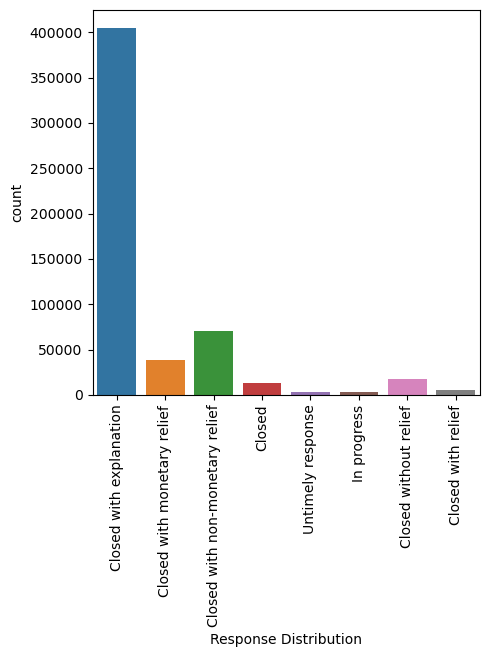

In [49]:
plt.figure(figsize = (5,5))
fig = sns.countplot(data = data, x = 'company_response_to_consumer')
fig.set_xticklabels(fig.get_xticklabels(), rotation=90)
plt.xlabel("Response Distribution")
plt.show()

#### Analysing Latency and Dispute Behaviour

In [51]:
print("maximum delay in receiving concern",data['latency'].max(), "days")
print("average delay in receiving concern",round(data['latency'].mean(), 3), "days")

maximum delay in receiving concern 993 days
average delay in receiving concern 4.657 days


In [52]:
print("Number of customers disputed even after timely response :", len(data[(data["timely_response"] == "Yes") & (data["consumer_disputed?"] == "Yes")]))

Number of customers disputed even after timely response : 110421


In [53]:
print("Number of customers disputed even after untimely response :", len(data[(data["timely_response"] == "No") & (data["consumer_disputed?"] == "Yes")]))

Number of customers disputed even after untimely response : 1713


In [54]:
print("Number of customers not disputed after timely response :", len(data[(data["timely_response"] == "Yes") & (data["consumer_disputed?"] == "No")]))

Number of customers not disputed after timely response : 431488


In [55]:
print("Number of customers not disputed even after untimely response :", len(data[(data["timely_response"] == "No") & (data["consumer_disputed?"] == "No")]))

Number of customers not disputed even after untimely response : 12335


#### Company Analysis

In [56]:
data["company"].value_counts().sort_values(ascending = False).head(20)

company
Bank of America                           55998
Wells Fargo & Company                     42024
JPMorgan Chase & Co.                      33881
Equifax                                   31828
Experian                                  30905
Citibank                                  25540
TransUnion Intermediate Holdings, Inc.    25534
Ocwen                                     20978
Capital One                               15628
Nationstar Mortgage                       13250
U.S. Bancorp                               9554
Synchrony Financial                        9435
Ditech Financial LLC                       8679
Navient Solutions, Inc.                    8007
PNC Bank N.A.                              6974
Encore Capital Group                       6304
HSBC North America Holdings Inc.           6180
Amex                                       5752
SunTrust Banks, Inc.                       4855
Discover                                   4765
Name: count, dtype: int64

In [57]:
len(data[(data["company"] == "Bank of America") & (data["consumer_disputed?"] == "Yes")])

12480

In [58]:
len(data[(data["company"] == "Bank of America") & (data["consumer_disputed?"] == "No")])

43518

In [59]:
data.head()

,product,issue,company,state,submitted_via,company_response_to_consumer,timely_response,consumer_disputed?,latency,day,month
0,Mortgage,"Loan modification,collection,foreclosure",U.S. Bancorp,CA,Referral,Closed with explanation,Yes,Yes,4,3,9
1,Mortgage,"Loan servicing, payments, escrow account",Wells Fargo & Company,CA,Referral,Closed with explanation,Yes,Yes,4,3,9
2,Credit reporting,Incorrect information on credit report,Wells Fargo & Company,NY,Postal mail,Closed with explanation,Yes,No,19,18,9
3,Student loan,Repaying your loan,"Navient Solutions, Inc.",MD,Email,Closed with explanation,Yes,Yes,0,30,8
4,Debt collection,False statements or representation,Resurgent Capital Services L.P.,GA,Web,Closed with explanation,Yes,Yes,0,30,8


#### Analysing Timelines of Complaint Registration and Results

In [60]:
len(data[(data["consumer_disputed?"] == "Yes") & (data["day"] > 15)])

56226

In [61]:
len(data[(data["consumer_disputed?"] == "Yes") & (data["day"] < 15)])

52025

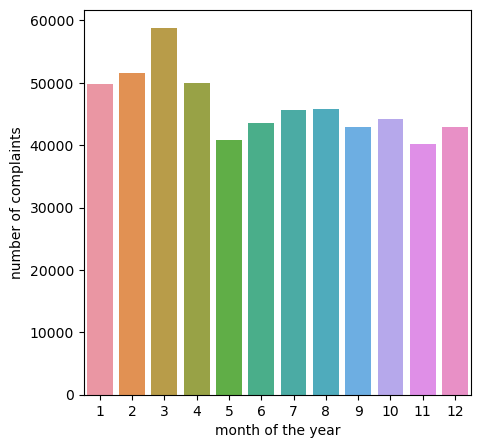

In [62]:
plt.figure(figsize = (5,5))
sns.countplot(data = data, x = "month")
plt.xlabel("month of the year")
plt.ylabel("number of complaints")
plt.show()

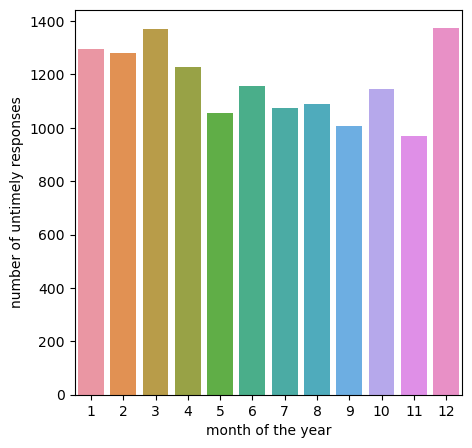

In [63]:
plt.figure(figsize = (5,5))
sns.countplot(data = data[data["timely_response"] == "No"], x = "month")
plt.xlabel("month of the year")
plt.ylabel("number of untimely responses")
plt.show()

### Data Preparation for Model Training

In [65]:
lc_prod = LabelEncoder()

In [66]:
lc_prod.fit(data["product"])
data["product"] = lc_prod.transform(data["product"])

In [67]:
lc_comp = LabelEncoder()
lc_comp.fit(data["company"])
data["company"] = lc_comp.transform(data["company"])

In [68]:
lc_state = LabelEncoder()
lc_state.fit(data["state"])
data["state"] = lc_state.transform(data["state"])

In [69]:
lc_submit = LabelEncoder()
lc_submit.fit(data["submitted_via"])
data["submitted_via"] = lc_submit.transform(data["submitted_via"])

In [70]:
lc_resp = LabelEncoder()
lc_resp.fit(data["company_response_to_consumer"])
data["company_response_to_consumer"] = lc_resp.transform(data["company_response_to_consumer"])

In [71]:
lc_opt = LabelEncoder()
lc_opt.fit(data["timely_response"])
data["timely_response"] = lc_opt.transform(data["timely_response"])
data["consumer_disputed?"] = lc_opt.transform(data["consumer_disputed?"])

In [72]:
data = data.drop(["issue"], axis = 1)

In [73]:
data.head()

,product,company,state,submitted_via,company_response_to_consumer,timely_response,consumer_disputed?,latency,day,month
0,6,3350,8,4,1,1,1,4,3,9
1,6,3520,8,4,1,1,1,4,3,9
2,3,3520,42,3,1,1,0,19,18,9
3,10,2333,26,0,1,1,1,0,30,8
4,4,2813,15,5,1,1,1,0,30,8


### Training and Testing Sets

In [74]:
y = data["consumer_disputed?"]
x = data.drop(['consumer_disputed?'], axis = 1)

In [75]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 42)

### Testing Models

In [76]:
def test_model(model):
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    #comparing with y_test
    prec_score = precision_score(y_test, y_pred, zero_division = 1)
    acc_score = accuracy_score(y_test, y_pred)
    print("precision score :", prec_score)
    print("accuracy score :", acc_score)

In [77]:
test_model(LogisticRegression())

precision score : 1.0
accuracy score : 0.7981569417464086


C:\anaconda1\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [78]:
test_model(DecisionTreeClassifier(criterion = 'entropy', random_state = 42))

precision score : 0.2398514194746617
accuracy score : 0.6923399764971101


In [79]:
test_model(RandomForestClassifier())

precision score : 0.3003423591658886
accuracy score : 0.775079741947862


In [80]:
test_model(AdaBoostClassifier(n_estimators = 10))

precision score : 1.0
accuracy score : 0.7981569417464086


In [81]:
test_model(KNN())

precision score : 0.2476166791013844
accuracy score : 0.7616495191500587


### Model Peformance

In [82]:
adaboost = AdaBoostClassifier()
adaboost.fit(x_train, y_train)

y_pred = adaboost.predict(x_test)

print(round(accuracy_score(y_test, y_pred), 3))

0.798


In [83]:
print("accuracy score = ", round(accuracy_score(y_test, y_pred), 3))

accuracy score =  0.798


### Saving the Model

In [84]:
joblib.dump(adaboost, "model.pkl")

['model.pkl']